In [2]:
#Just run this box once with 'Shift'+'Enter'. It loads all the things you need to work with the data. 
from __future__ import print_function

import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import datacube

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff

sys.path.append('../Scripts/')

%matplotlib inline

import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

# Enter your variables in the box below and choose values

Barmah choke: 
lat = -35.92
lon = 145.00
buffer = 10000

Boundary Bend:
lat = -34.71966901
lon = 143.1698626
buffer = 10000

Niemur:
lat = -35.277
lon = 144.3477
buffer = 5500

Macquarie Marshes:
lat = -30.8072
lon = 147.5149
buffer = 10000

Gunbower:
lat = -35.942574
lon = 144.46466
buffer = 10000

Wee Wai:
lat = -30.2033
lon = 149.4361
buffer = 10000

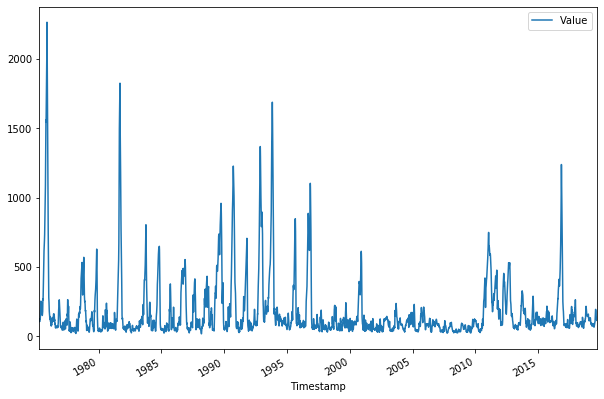

In [4]:
#What are the latitudes and longtitudes of the area you want to make a picture of?
lat = -34.71966901
lon = 143.1698626
buffer = 7000
#Where abouts is your csv file located on your computer?
csv_file_location = 'Boundary_Bend.csv'

#Loading and organising guage data
gauge_data = pd.read_csv(csv_file_location,
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is date format
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))
gauge_data = gauge_data.dropna()

gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')
gauge_data.plot(y='Value', figsize=(10,7))

In [5]:
#What discharge level range do you want to look at?
yaxis_lower_parameter = 300
yaxis_higher_parameter = 2500

#Dask loading wofs_albers data
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), 
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

#convert Pandas dataframe to xArray for merging with WOfS
gauge_data_xr = gauge_data.to_xarray() 

#this is the xArray merge function
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) 

#Now define the passes to load based on user input
specified_satellite_passes = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
specified_satellite_passes = specified_satellite_passes.drop('Timestamp')

#Check how many passes you are about to load. I recommend loading 100 to 400 passes.
specified_satellite_passes  

<xarray.Dataset>
Dimensions:  (time: 177)
Coordinates:
  * time     (time) datetime64[ns] 1988-07-30T23:45:44.500000 ... 2016-12-11T00:17:28.500000
Data variables:
    Value    (time) float64 348.6 388.6 419.4 431.1 ... 560.8 532.3 360.6 343.2

# Load satellite data so you can cloud mask it

In [7]:
#make a list of dates for the for-loop to load
date_list = specified_satellite_passes.time.values

#Re-do query without time
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer), 
         'crs': 'EPSG:3577'} 

#loop selecting data based on user input
xr_list = []
for date in date_list:
    date = str(date)  
    wofs_albers= dc.load(product = 'wofs_albers', time=date,  **query)
    xr_list.append(wofs_albers)
specified_passes = xr.concat(xr_list, dim='time')

#Cloud Mask
ClearTimesteps = []
for ix, timestep in enumerate(specified_passes.time):
    SingleTime = specified_passes.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()   
    PercentCloudy = CountClouds.values.item()/(len(specified_passes.x)*len(specified_passes.y))*100
    IsItClearEnough = PercentCloudy <= 20  
    if IsItClearEnough:
        ClearTimesteps.append(ix)     
clear_specified_passes = specified_passes.water.isel(time = ClearTimesteps)
#See how many clear passes you got. I would recommend to have at least 50 for this application:
clear_specified_passes

<xarray.DataArray 'water' (time: 138, y: 561, x: 561)>
array([[[  8,   8, ..., 139, 139],
        [  8,   8, ..., 139, 139],
        ...,
        [ 10,  10, ..., 139, 139],
        [ 10,  10, ..., 139, 139]],

       [[  8,   8, ...,   8,   8],
        [  8,   8, ...,   8,   8],
        ...,
        [  8,   8, ...,   8,   8],
        [  8,   8, ...,   8,   8]],

       ...,

       [[  0,   0, ..., 131, 131],
        [  0,   0, ..., 131, 131],
        ...,
        [  0,   0, ..., 131, 131],
        [  0,   0, ..., 131, 131]],

       [[  0,   0, ...,   2, 130],
        [  0,   0, ...,   0,   0],
        ...,
        [  0,   0, ...,   0,   0],
        [  0,   0, ..., 131, 131]]], dtype=int16)
Coordinates:
  * y        (y) float64 -3.828e+06 -3.828e+06 ... -3.842e+06 -3.842e+06
  * x        (x) float64 1.011e+06 1.011e+06 1.011e+06 ... 1.025e+06 1.025e+06
  * time     (time) datetime64[ns] 1988-08-06T23:51:54.500000 ... 2016-12-11T00:17:28.500000
Attributes:
    units:             1
    

# Use pandas to merge the clear satellite data with the gauge data and plot. 

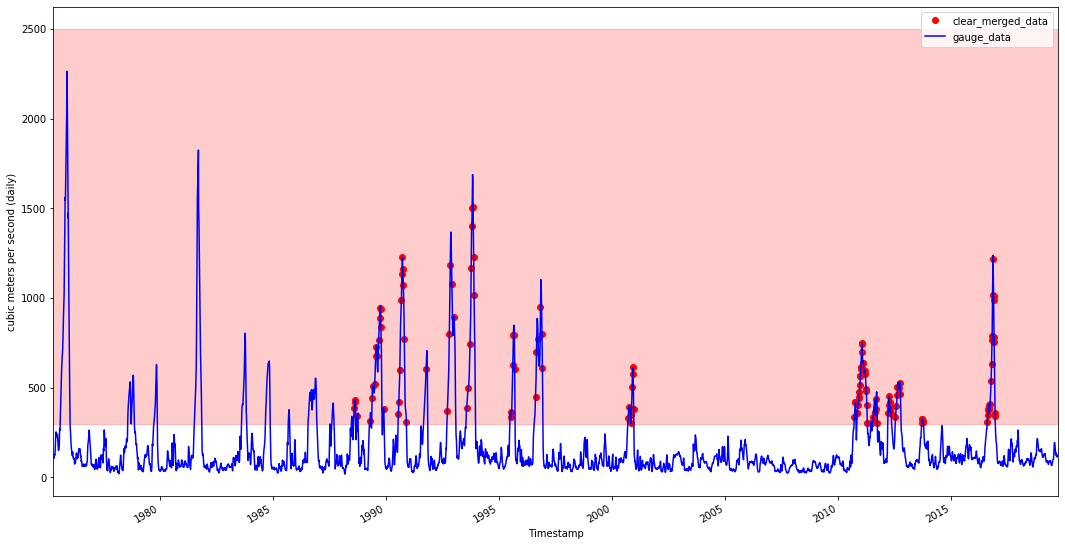

In [9]:
#Now take the clear passes and make it into a pandas dataframe that lists time of clear passes and corresponding gauge value
clear_specified_passes_pd = clear_specified_passes.time.to_dataframe()
clear_specified_passes_pd = clear_specified_passes_pd.rename(columns = {'time': 'date'})#can't have 2 columns called 'time' for the merge
merged_data_pd = merged_data.to_dataframe()

#Merge clear satellite passes with gauge data by the time dimension
clear_merged_data = pd.merge(clear_specified_passes_pd, merged_data_pd, left_on= 'time', 
                            right_index=True, how='inner')
clear_merged_data = clear_merged_data.drop(columns='date')
clear_merged_data = clear_merged_data.drop(columns='Timestamp')

#Plot the clear satellite passes over the hydrograph
ax = clear_merged_data.plot(marker = 'o', color='red', linestyle = 'None', figsize=(18,10))
plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
plt.ylabel('cubic meters per second (daily)')
gauge_data.plot(ax=ax, color='blue')
ax.legend(["clear_merged_data", "gauge_data"]);

# Use scipy.signal to define whether the water is rising or receding

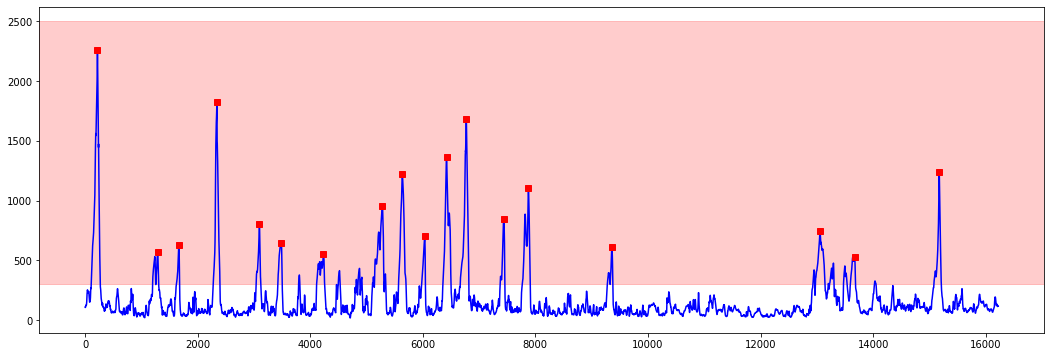

In [10]:
import scipy.signal

xx = gauge_data.values.ravel()
pp,_ = scipy.signal.find_peaks(xx, height=500, width=20, distance=100)

fig, ax = plt.subplots(1, figsize=(18, 6))
ax.plot(xx, 'b-')
ax.plot(pp, xx[pp], 'rs');
plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)


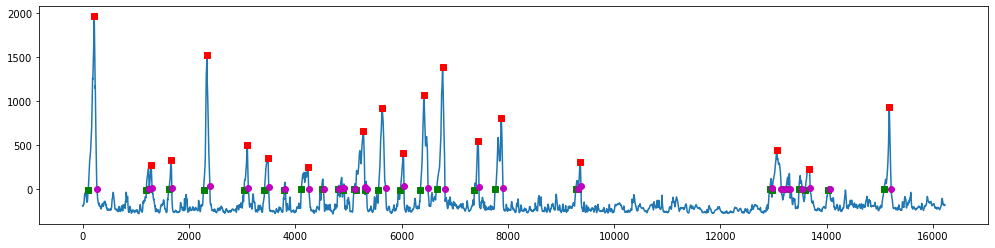

In [11]:
xx = gauge_data.values.ravel() - yaxis_lower_parameter
hi = xx > 0
lo = xx <= 0
crosses_up = lo[:-1] * hi[1:] 
crosses_lo = hi[:-1]*lo[1:]

crosses_up = np.hstack([crosses_up, np.r_[False]])
crosses_lo = np.hstack([crosses_lo, np.r_[False]])

ii = np.arange(0, xx.shape[0])
fig, ax = plt.subplots(1, figsize=(17,4))
ax.plot(ii, xx, '-', 
        ii[crosses_up], xx[crosses_up] , 'gs',
        ii[crosses_lo], xx[crosses_lo] , 'mo',

        ii[pp], xx[pp], 'rs'
       );

#green squares are called crosses_up
#purple circles are called crosses_lo
#Red squares are called pp
#Hydrograph data (blue line) is called gauge_data